# ASTR 420: Absolute Magnitudes & Luminosity Functions

In previous sessions we have been looking at correlations between apparent magnitude and other observable properties of galaxies like color and redshift.  One of the most fundamental observational results of the Sloan Digital Sky Survey was the characterization of the galaxy color-magnitude diagram.  We have tried exploring this diagram in prevous exercises, but always using apparent magnitudes.  As you have discovered, the apparent brightness of an object depends on many things, including: intrinsic luminosity, distance, dust extinction, and [k-corrections](https://ned.ipac.caltech.edu/level5/Sept02/Hogg/frames.html).

Today we will work with one of the [NYU Value Added Catalogs](https://cosmo.nyu.edu/blanton/vagc/), which provide (among other useful things) pre-calculated absolute magnitudes for galaxies observed in earlier data releases of the SDSS.  These data will enable us to improve our measurements of the galaxy color-magnitude diagram, and explore techniques for creating volume-limited samples and quantifying the luminosity function of galaxies.

Let's start by importing some useful libraries:

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm
%matplotlib inline

The data we need to use is not loaded into the SDSS database, so we will need to pull it from [this table of low-redshift galaxies](http://sdss.physics.nyu.edu/vagc/lowz.html) on the NYU VAC site.  

First, make sure you have downloaded the catalog called 'lowz_catalog.dr4.fits' into the directory where you are running this notebook. 

Next, let's define a function that will do this for any fits data table file, and then feed it the catalog file. 

In [3]:
def load_fits(fname):
    hdu = fits.open(fname)[1] #loads the fits file into python
    data = hdu.data      #accesses the data table
    return data

lowz_full = load_fits('lowz_catalog.dr4.fits')


We now have three sets of data. Each of our datasets above has multiple columns being stored in what is known as a "record array" (or rec.array). This is a form of array that allows indexing by attribue, much like a dictionary. We can print out what the column names are by using dot notation on our data sets. 

In [4]:
lowz_full.columns

ColDefs(
    name = 'OBJECT_POSITION'; format = 'J'
    name = 'ICOMB'; format = 'J'
    name = 'SECTOR'; format = 'J'
    name = 'VAGC_SELECT'; format = 'J'
    name = 'FGOTMAIN'; format = 'E'
    name = 'MMAX'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'RUN'; format = 'J'
    name = 'RERUN'; format = '3A'
    name = 'CAMCOL'; format = 'J'
    name = 'FIELD'; format = 'J'
    name = 'ID'; format = 'J'
    name = 'OBJC_ROWC'; format = 'J'
    name = 'OBJC_COLC'; format = 'J'
    name = 'PLATE'; format = 'J'
    name = 'FIBERID'; format = 'J'
    name = 'MJD'; format = 'J'
    name = 'PLUG_RA'; format = 'D'
    name = 'PLUG_DEC'; format = 'D'
    name = 'QUALITY'; format = 'J'
    name = 'ABSMAG'; format = '8E'
    name = 'ABSMAG_IVAR'; format = '8E'
    name = 'MU50R'; format = 'E'
    name = 'PSF_FWHM'; format = '5E'
    name = 'KCORRECT'; format = '8E'
    name = 'PETROFLUX'; format = '5E'
    name = 'PETROFLUX_IVAR'; format = '5E'
    name 

As we can see, we have columns like "RA", "DEC", "ABSMAG", "KCORRECT", etc. 

For the purposes of this tutorial, we are interested in the following columns:

- "ABSMAG" = An 8-item list for each object, which contains the absolute magnitude (AB) in the ugrizJHKs bandpasses (first five from SDSS Petrosian magnitude, last three from 2MASS XSC) K-corrected and Galactic extinction corrected using the SFD dust maps

- "ZDIST" = the redshift from SDSS, corrected for the peculiar velocity relative to the Local Group 

For a full description of each column, check the documentation [here](https://cosmo.nyu.edu/blanton/vagc/lowz.html).



In [5]:
## Note that the ABSMAG data for SDSS filters u,g,r,i,z can be accessed in the following way:

abs_u=lowz_full['ABSMAG'][:,0]
abs_g=lowz_full['ABSMAG'][:,1]
abs_r=lowz_full['ABSMAG'][:,2]
abs_i=lowz_full['ABSMAG'][:,3]
abs_z=lowz_full['ABSMAG'][:,4]



Now let's start by taking a look at the redshift distribution of the galaxies in the table:

Number of galaxies:  49968


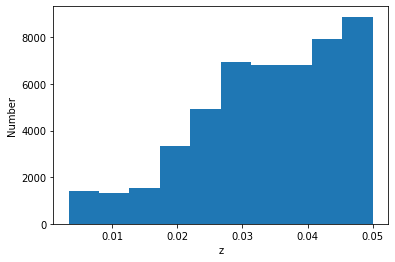

In [6]:
print("Number of galaxies: ", len(lowz_full['ZDIST']))

plt.hist(lowz_full['ZDIST'])
plt.xlabel('z')
plt.ylabel('Number')
plt.show()

**Interpretation:** Can you explain the shape of this distribution?

Next, let's take a look at the distribution of magnitudes in one of the SDSS bands:


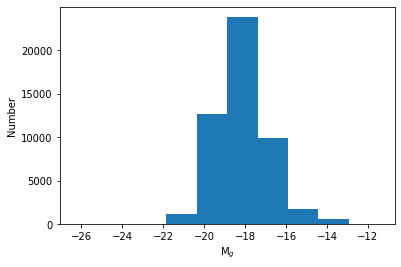

In [34]:


plt.hist(abs_g)
plt.xlabel('M$_{g}$')
plt.ylabel('Number')
plt.show()


**Interpretation:** At first glance, this looks very different from measurements of the apparent magnitudes of galaxies in earlier tutorials. The distribution here is peaked at large negative numbers. But remember that these are *absolute magnitudes*. This is probably just what you'd expect to represent the brightness of a galaxy if it were only 10pc away!

Now let's try making a color-magnitude diagram for these galaxies...  

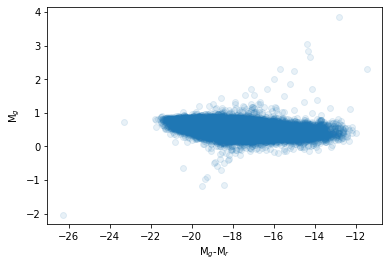

In [12]:
color_gr = abs_g - abs_r

plt.scatter(abs_g, color_gr, alpha=0.1)
plt.xlabel('M$_{g}$-M$_{r}$')
plt.ylabel('M$_{g}$')
plt.show()

Even with a high transparency setting (i.e., alpha=0.1), that looks pretty hard to interpret.  

Let's try making a density plot to better resolve where the highest density regions are in this parameter space.



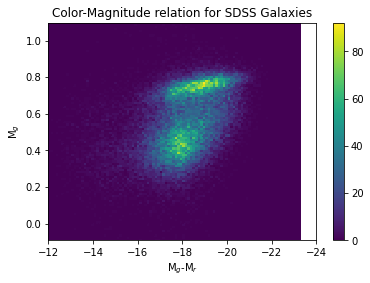

In [15]:
# let's filter out some of the outlier galaxies with really weird colors
restrictions = np.where((color_gr > -0.1) & (color_gr<1.1))


plt.hist2d(abs_g[restrictions], color_gr[restrictions], bins=100)
plt.colorbar()
plt.title('Color-Magnitude relation for SDSS Galaxies')
plt.xlabel('M$_{g}$-M$_{r}$')
plt.ylabel('M$_{g}$')
plt.xlim(-12,-24)
plt.show()

**Interpretation:** That looks much better!  Now the blue cloud and the red sequence really stand out.  You can appreciate how much cleaner this color-magnitude diagram looks when you use *absolute* magnitudes, instead of *apparent* magnitudes.

----------
## Pitfalls of Flux-Limited Surveys

Recall from previous activities, the discussion of "Malmquist" bias.. in which the most distant objects in our sample are biased toward being more luminous, on average.  This was illustrated well by Hubble in "The Realm of the Nebulae":

<img src="img/malmquist.png" style="width: 600px;">

As we start looking to higher redshifts, even though we are sampling larger volumes of space, it becomes increasingly more difficult to detect low-luminosity objects.  Therefore, when you're using data from a "flux-limited" sample like the SDSS (in which most of the survey area was taken with the same exposure time, and is therefore equally deep), the data are bound to be "incomplete" at different combinations of luminosity and redshift.  

Since our galaxies are selected from a range in redshifts, let's make a plot of absolute magnitude versus redshift to see how "complete" the sample is. 

Let's make that plot below:

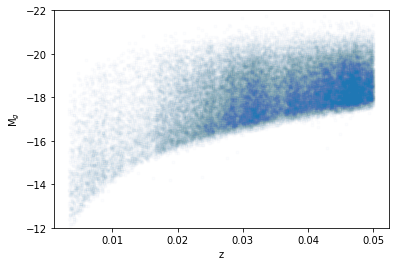

In [16]:
plt.scatter(lowz_full['ZDIST'], abs_g, marker='.', alpha=0.01)
plt.xlabel('z')
plt.ylabel('M$_{g}$')
plt.ylim(-12,-22)
plt.show()

In the plot above, you can see a distinct edge in the distribution, where at different redshifts, galaxies below a certain luminosity value are not observable in the SDSS sample.

In order to not be biased by this when we make statistical measurements of the galaxy properties at different redshifts, we will need to make "volume-limited" samples.  These are subsets of the data that are cut for completeness at different ranges in absolute magnitude and redshift.

<img src="img/vollim.png" style="width: 600px;">

Let's try making one volume-limited sample out of the data we have in-hand.  To do so, pick a redshift that you'd like to extend out to, and then determine the faint-end cut-off in absolute magnitude at that redshift. 

maximum count:  2155.0
maximum gMag:  [-17.149609]


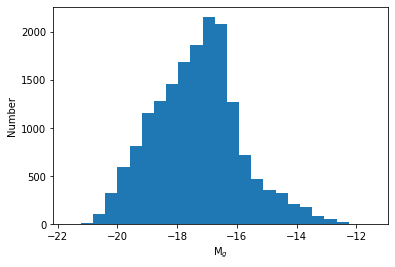

In [19]:
# Let's make a subsample that extends out to redshift 0.03
z_ulim = 0.03
zcut = np.where(lowz_full['ZDIST']<z_ulim)

# you can find the peak value of the histogram this way:
(n, bins, patches) = plt.hist(abs_g[zcut],bins=25)
print('maximum count: ', max(n))
print('maximum gMag: ', bins[np.where(n==max(n))])
max_gMag= bins[np.where(n==max(n))]

plt.ylabel('Number')
plt.xlabel('M$_{g}$')
plt.show()


Now that we've located the absolute magnitude edge in the data at our chosen maximum redshift value, let's apply a cut to extract a complete, "volume-limited" sample:

2155.0


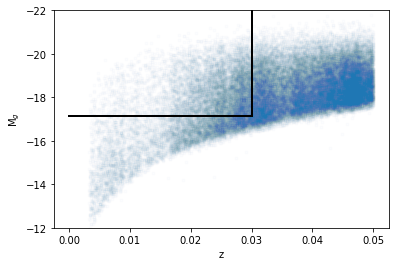

In [21]:
# Here's a plot just to check that the limits we've chosen are reasonable
plt.scatter(lowz_full['ZDIST'], abs_g, marker='.', alpha=0.01)

print(max(n))
# draw vertical line
plt.plot([z_ulim, z_ulim], [-22, max_gMag], 'k-', lw=2)
# draw a horizontal line
plt.plot([0,z_ulim],[max_gMag, max_gMag], 'k-', lw=2)
plt.xlabel('z')
plt.ylabel('M$_{g}$')
plt.ylim(-12,-22)
plt.show()


This initial guess using the absolute magnitude distribution looks a little conservative... so you might want to adjust it to get a little closer to the edge of the distribution.  It's OK to be overly-conservative; it just means you'll be throwing away possibly useful data.

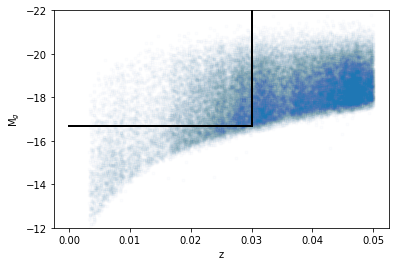

In [24]:
# Let's make the limits less conservative, and get closer to the real completness threshold
z_ulim=0.03
max_gMag=-16.7

plt.scatter(lowz_full['ZDIST'], abs_g, marker='.', alpha=0.01)
plt.plot([z_ulim, z_ulim], [-22, max_gMag], 'k-', lw=2)
# draw a horizontal line
plt.plot([0,z_ulim],[max_gMag, max_gMag], 'k-', lw=2)
plt.xlabel('z')
plt.ylabel('M$_{g}$')
plt.ylim(-12,-22)
plt.show()

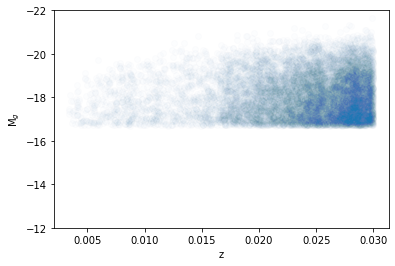

In [25]:
# Let's try slicing the data at these limits and make sure it all looks right

vollimcut = np.where((lowz_full['ZDIST']<z_ulim) & (abs_g< max_gMag))

plt.scatter(lowz_full['ZDIST'][vollimcut], abs_g[vollimcut], alpha=0.01)
plt.xlabel('z')
plt.ylabel('M$_{g}$')
plt.ylim(-12,-22)
plt.show()

Voila!  You have a volume-limited sample!  You can now ask questions of the data and not be worried that you are being biased by incompleteness of your sample on the faint-end.  Excellent!

You now have what you need to make another extremely useful measurement in galaxy evolution studies: the **Luminosity Function**.  This measured function is defined as the number density of galaxies in a particular sample with absolute magnitudes between M and M+dM.  The luminosity number density function is quantified as:

$\Phi_{s}(M)= \frac{N(M)}{V(M)}$

where $N(M)$ is the number of galaxies, as a function of absolute magnitude, and $V(M)$ is the volume of the data in which the galaxies have been sampled.

We can quite easily count up the number of galaxies in different absolute magnitude (i.e., luminosity) bins, using the histogram function:

Galaxies:  [   5.   50.  259.  630.  974. 1416. 1706. 1869. 2208. 2608.]
g_Mags:  [-21.63034  -21.137333 -20.644323 -20.151316 -19.658308 -19.165298
 -18.67229  -18.179283 -17.686275 -17.193266 -16.700258]


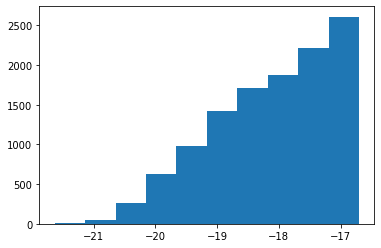

In [26]:
(N_M, bins_M, patches_M)=plt.hist(abs_g[vollimcut])
print("Galaxies: ", N_M)
print("g_Mags: ",bins_M)

**Let's make a simple plot of N(M).. the number of galaxies as a function of absolute magnitude:**

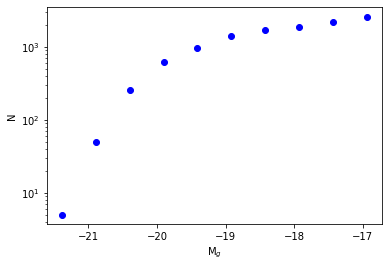

In [36]:
# Note that the histogram function returns binning information that is one item longer than the list of number counts.
# This is because the returned bins is a list of the edges of each bin in the histogram, not their centers.
# You can convert the bin edges to bin centers using a simple function:
def bincenters(bin_arr):
    bin_centers = []
    for m in range(0,len(bin_arr)-1):
        bin_centers.append((bin_arr[m]+bin_arr[m+1])/2.)
    return(bin_centers)

plt.semilogy(bincenters(bins_M), N_M, 'bo')
plt.ylabel('N')
plt.xlabel('M$_{g}$')
plt.show()

Voila!  This is the simplest form of a luminosity function.  Note that we have not divided our counts by the total volume, which must ultimately still be done if we want to measure the true density of different types of objects or to compare samples taken in different volumes of space.

Let's compare with a classical measurement from Binggeli, Sandage, and Tamman (1988):

<img src="img/BST1988.png" style="width: 600px;">

**Interpretation:** Does the overall shape of your measurement, which has not further selected galaxies by shape or color) look similar to this "Total" luminosity function measurement shown above?


------------

## Measuring the Luminosity Number Density Function at different redshifts:

Measurements of the luminosity function, split by galaxy type (see the figure above), have revealed that there is no universal luminosity function for galaxies.  It can be seen to clearly differ for samples with different morphologies, stellar populations, and environments.  Furthermore, comparing luminosity functions at different redshifts gives us critical insight into how galaxies evolve with time.  As they build up their stellar mass they should increasingly populate the high-luminosity end of the luminosity function.  Observing how the shape of this function changes with time for certain types of galaxies, provides important information about how galaxies evolve and also provide constraints for simulations.

Recall that so far we have only counted the number of galaxies, as a function of luminosity, in a volume-limited sample with a single redshift range.  In order to properly compare the shapes of the luminosity functions for samples of galaxies at different redshifts, we'll need to properly account for the different volumes sampled in each measurement.  A short tutorial on how to calculate volume in sky surveys is provided below:

**1. Calculating the total area of the sky:**

   Recall that a great circle that bisects the sky (i.e., the celestial sphere) is 360 degrees around, and areas on the sky are measured in units of square degrees ($deg^{2}$).  

   The circumference of a circle is:
   $2\pi\times (radius)$, which can also be described as 360 degrees in angular units.
   
   Solving the circumference equation for the radius gives:

   radius = $\frac{360}{2\pi}=57.2958$ degrees 

   Since the surface area of a sphere is:
   $4\pi\times (radius)^{2}$

   the total area of the celestial sphere (i.e., the sky) must be approximately: 
   $4\pi\times (57.3~deg) ^{2}= $ **41,253** $deg^{2}$

**2. Calculating volumes of space sampled by a survey:**
    
   Suppose you are sampling the entire sky out to a certain redshift.  The volume enclosed in your survey would be defined as the volume of a sphere, with a radius equal to the physical distance to the redshift limit of your sample:
 ![vol1](img/sphere_vol.jpg)  $volume = \frac{4}{3}\pi r^{3}$
    
   Measurements of volume in the universe can be a little complicated due to the fact that the universe is expanding with time.  That means, at higher redshift, the entire volume of the universe was smaller than it is at lower redshift (or today, where redshift (z) = 0).  For this reason, it is common practice in astronomy to define volumes of space as "comoving" -- meaning that the number densities (i.e., number per unit volume) for a fixed number of objects remain constant with redshift. The comoving volume ($V_{c}$) is effectively a measurement of a volume, corrected for the effects of cosmic expansion.
   
   Measuring a comoving volume defined by a radius (measured as some redshift) is not a simple calculation, and it depends on a number of cosmological parameters (e.g., the relative energy densities of matter, radiation, and dark energy in the universe, Hubble's constant, and curvature).  The [Astropy](http://www.astropy.org/) library contains a number of [helpful functions for cosmology calculations](http://docs.astropy.org/en/stable/cosmology/), but you still need to tell it which cosmological parameters you want to use.  The good news is that after a century of observations and improvements to various methodologies, cosmologists have pretty well constrained possible models of the universe and have measured the key parameters with high precision. (Although some mysteries remain as to why different methods produce slightly different determinations of the Hubble constant, etc.,).
  
   Today, most of the observational data support a cosmological model referred to as ["Flat Lambda CDM](https://lambda.gsfc.nasa.gov/education/graphic_history/), which means a "flat" universe that has zero curvature, plus a "Lambda" component (that's another name for the mysterious "dark energy" that dominates our modern universe and drives its accelerating expansion), and an additional compoment of cold (non-relativistic) dark matter ("CDM").   
   
   Below is an example of how to import the Flat Lambda CDM cosmological model, given some chosen parameters:
     - Hubble's constant at z=0 (H0) = 100 km/s/Mpc
     - CMB temperature at z=0 (Tcmb0)=2.725
     - matter density parameter at z=0 (Om0)=0.3 ; (i.e, the combined energy density of normal (baryonic) and dark matter is 30% of the total energy density today)
  


In [37]:
# Importing the cosmology of choice from astropy

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=100 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)



Now let's make a simple calculation using this model...

In [38]:

# Print out the age of the universe at z=0 (today)
print("The age of the universe today: ", cosmo.age(0)  )


The age of the universe today:  9.425060465711672 Gyr




Uh... that's probably not what you learned in your last astronomy class.  Maybe we were a little careless with those choices of parameters.

Let's try importing another Flat Lambda CDM model that uses the latest and greatest parameter measurements from the [Planck](https://www.cosmos.esa.int/web/planck/home) cosmic microwave background radiation analysis:


In [39]:
# Importing the new cosmology of choice from astropy
from astropy.cosmology import Planck15 as cosmo

# Print out the age of the universe at z=0 (today)
print("The age of the universe today: ", cosmo.age(0)  )
 


The age of the universe today:  13.797615896896387 Gyr


Ah, OK.  That sounds more inline with the current consensus!  Let's use the Planck best-fit cosmology moving forward.

Now let's see what that parameters this model assumes and calculate a few useful things:

In [32]:

#  the value of the Hubble constant at the current time
print("Hubble constant at z=0: ", cosmo.H(0))
print()

#  the matter energy density at the current time
print("Matter density parameter at z=0: ", cosmo.Om(0))
print("This means matter (dark matter + baryonic) make up %.2f percent of the total energy density of the universe today! \n" % (100*cosmo.Om(0)))

# For a flat universe (which Planck data indicate), all of the density parameters (matter, radiation, and dark energy) add up to 1.0
# All observations agree that the density of radiation in the current time is << 1.
# So, the dark energy density at the current time can be well-approximated as 1.0 minus the matter density parameter

print("Dark energy density parameter at z=0: ", 1-cosmo.Om(0))
print("This means dark energy makes up %.2f percent of the total energy density of the universe today! \n" % (100*(1.-cosmo.Om(0))))

# Print out the age of the universe at z=1 
print("The age of the universe at z=1: ", cosmo.age(1.0)  )
print()


# calculate the comoving distance defined by redshifts 0.5, 1.0, & 1.5
print("Comoving distances to redshifts 0.5, 1.0, & 1.5: ", cosmo.comoving_distance([0.5, 1.0, 1.5])  )

Hubble constant at z=0:  67.74 km / (Mpc s)

Matter density parameter at z=0:  0.3075
This means matter (dark matter + baryonic) make up 30.75 percent of the total energy density of the universe today! 

Dark energy density parameter at z=0:  0.6925
This means dark energy makes up 69.25 percent of the total energy density of the universe today! 

The age of the universe at z=1:  5.862549255024051 Gyr

Comoving distances to redshifts 0.5, 1.0, & 1.5:  [1945.56126208 3395.90531198 4479.04518283] Mpc





**Note:** If you want to double-check whether you're using these Astropy functions correctly, you can refer to the [documentation](http://docs.astropy.org/en/stable/index.html) and/or try comparing to calculations with this handy [online cosmology calculator](http://www.astro.ucla.edu/~wright/CosmoCalc.html) from Ned Wright.

---------------------------------
**YOUR TURN:**

Using the comoving distance as a measurement of radius, calculate the comoving volume enclosed by a survey of the total sky out to z=1:

In [5]:
# YOUR CODE HERE



-------------------------    
Now suppose we are sampling a region of the sky that is bounded by an upper and lower redshift value, where z>0.  This sounds like you might need some careful calculus, but in fact, there's a simple geometric trick that makes the measurement easy:

The volume of a spherical shell is simply the difference between the enclosed volume of the outer sphere and the enclosed volume of the inner sphere:

$V=\frac {4}{3}\pi R^{3}-\frac{4}{3}\pi r^{3}$  

where r is the radius of the inner sphere and R is the radius of the outer sphere.




<img src="img/Volume.png" style="width: 600px;">


**YOUR TURN:**

Calculate the comoving volume of space sampled by a survey that covers the entire sky, but only in the redshift range 0.2<z<0.3:

In [1]:
# YOUR CODE HERE



**YOUR TURN:**

Now you have all the tools to measure the luminosity number density function of galaxies in a redshift-limited sample of the sky.  

Measure this function for a volume-limited sample of galaxies in the redshift range 0.01<z<0.02.   You will need to:
   - create a volume-limited subset of the data extending to z=0.02
   - Calculate the volume of space covered by this subset of the survey
   - Plot the number density of galaxies (# of galaxies / Mpc$^{3}$) as a function of absolute magnitude in this sample.  Make sure to carefully label your axes with the proper units.
    
**Important note:** The NYU Low-Redshift Value-Added Catalog that you read and analyzed for the first part of this exercise is drawn from the Data Release 4 of the Sloan Digital Sky Survey.  At that time, the "footprint" of the survey covered 6670 deg$^{2}$.  Therefore, your comoving volume will not span the entire sky, but just a portion of it.  Make sure this information is folded in, or else your number densities will be way too small!

In [ ]:
# YOUR CODE HERE



**YOUR TURN:**

Now, make the same measurement for a sample of galaxies spanning 0.035<z<0.045:

In [ ]:
# YOUR CODE HERE

**YOUR TURN:**

Overplot the luminosity number density functions of two redshift samples in the cell below.


In [2]:
# YOUR CODE HERE

**Questions to answer:**

    - In what ways are the functions similar, and how do you interpret that?
    - In what ways are the functions different, and how do you interpret that?

Your responses here....